# Reinforcement Learning - Temporal Difference
In this assignment you will impement and compare temporal difference methods (SARSA and Q-learning).

In [1]:
# This cell imports %%execwritefile command (executes cell and writes it into file). 
# All cells that start with %%execwritefile should be in td_autograde.py file after running all cells.

from custommagics import CustomMagics
get_ipython().register_magics(CustomMagics)

In [2]:
%%execwritefile td_autograde.py
import numpy as np
from collections import defaultdict
from tqdm import tqdm as _tqdm

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

Overwriting td_autograde.py


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys

import random
import time
assert sys.version_info[:3] >= (3, 7, 0), "Make sure you have Python 3.7 installed!"

## 1. Temporal Difference (TD) learning

For the TD algorithms, we will skip the prediction algorithm and go straight for the control setting where we optimize the policy that we are using. To keep it dynamic, we will use the windy gridworld environment (Example 6.5 in the book).

In [4]:
from windy_gridworld import WindyGridworldEnv
env = WindyGridworldEnv()

Implement the EpsilonGreedyPolicy class which uses Q-values to sample an action.

In [5]:
%%execwritefile -a td_autograde.py

class EpsilonGreedyPolicy(object):
    """
    A simple epsilon greedy policy.
    """
    def __init__(self, Q, epsilon):
        self.Q = Q
        self.epsilon = epsilon
    
    def sample_action(self, state):
        """
        This method takes a state as input and returns an action sampled from this policy.  

        Args:
            state: current state

        Returns:
            An action (int).
        """
        
        # YOUR CODE HERE
        sample_space_actions = range(len(self.Q[state]))
        
        if np.random.rand() < self.epsilon:
            action = np.random.choice(sample_space_actions)
        else:
            action = np.argmax(self.Q[state])
        
        return action

Appending to td_autograde.py


Now implement SARSA.

In [6]:
%%execwritefile -a td_autograde.py

def sarsa(env, policy, Q, num_episodes, discount_factor=1.0, alpha=0.5):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        policy: A policy which allows us to sample actions with its sample_action method.
        Q: Q value function, numpy array Q[s,a] -> state-action value.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        
    Returns:
        A tuple (Q, stats).
        Q is a numpy array Q[s,a] -> state-action value.
        stats is a list of tuples giving the episode lengths and returns.
    """
    
    # Keeps track of useful statistics
    stats = []
    
    for i_episode in tqdm(range(num_episodes)):
        i = 0 
        R = 0 
        
        # YOUR CODE HERE
        state = env.reset()
        action = policy.sample_action(state)
        done = False

        while not done:
            state_new, reward, done, _ = env.step(action)
            
            R += reward
            i += 1
            
            action_new = policy.sample_action(state_new)
            Q[state, action] += alpha * (reward + discount_factor * Q[state_new, action_new] - Q[state, action])
            state, action = state_new, action_new
        
        stats.append((i, R))
        
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)

Appending to td_autograde.py


In [7]:
def running_mean(vals, n=1):
    cumvals = np.array(vals).cumsum()
    return (cumvals[n:] - cumvals[:-n]) / n

100%|██████████| 1000/1000 [00:01<00:00, 544.00it/s]


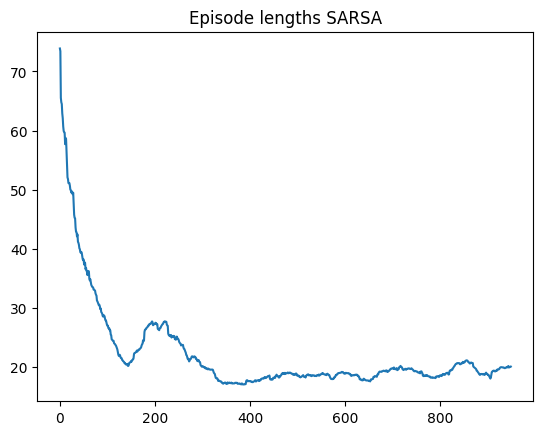

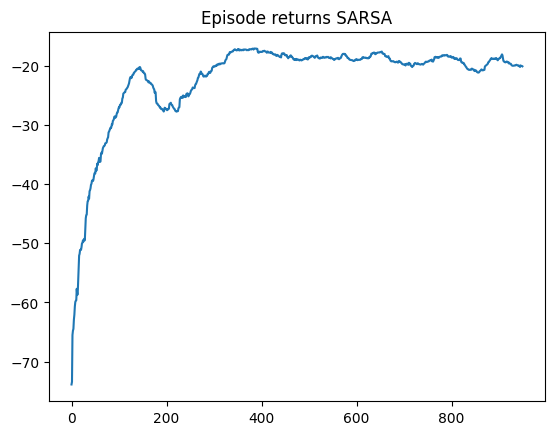

In [8]:
Q = np.zeros((env.nS, env.nA))
policy = EpsilonGreedyPolicy(Q, epsilon=0.1)
Q_sarsa, (episode_lengths_sarsa, episode_returns_sarsa) = sarsa(env, policy, Q, 1000)

n = 50
# We will help you with plotting this time
plt.plot(running_mean(episode_lengths_sarsa,n))
plt.title('Episode lengths SARSA')
plt.show()
plt.plot(running_mean(episode_returns_sarsa,n))
plt.title('Episode returns SARSA')
plt.show()

We can also learn the optimal (non-exploring) policy while using another policy to do exploration, which is where we arrive at _off-policy_ learning. In the simplest variant, we learn our own value by bootstrapping based on the action value corresponding to the best action we could take, while the exploration policy actual follows the $\epsilon$-greedy strategy. This is known as Q-learning.

In [9]:
%%execwritefile -a td_autograde.py

def q_learning(env, policy, Q, num_episodes, discount_factor=1.0, alpha=0.5):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        policy: A behavior policy which allows us to sample actions with its sample_action method.
        Q: Q value function
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        
    Returns:
        A tuple (Q, stats).
        Q is a numpy array Q[s,a] -> state-action value.
        stats is a list of tuples giving the episode lengths and returns.
    """
    
    # Keeps track of useful statistics
    stats = []
    
    for i_episode in tqdm(range(num_episodes)):
        i = 0
        R = 0
    
        # YOUR CODE HERE
        state = env.reset()
        done = False

        while not done:
            action = policy.sample_action(state)
            state_new, reward, done, _ = env.step(action)

            R += reward
            i += 1
            
            action_new = np.argmax(Q[state_new])
            Q[state, action] += alpha * (reward + discount_factor * Q[state_new, action_new] - Q[state, action])
            state = state_new

        stats.append((i, R))
        
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)

Appending to td_autograde.py


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:02<00:00, 435.30it/s]


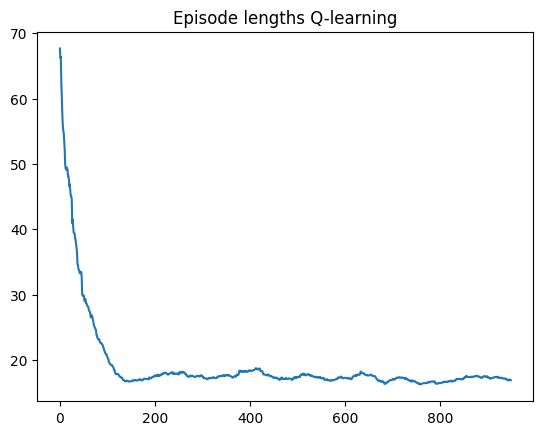

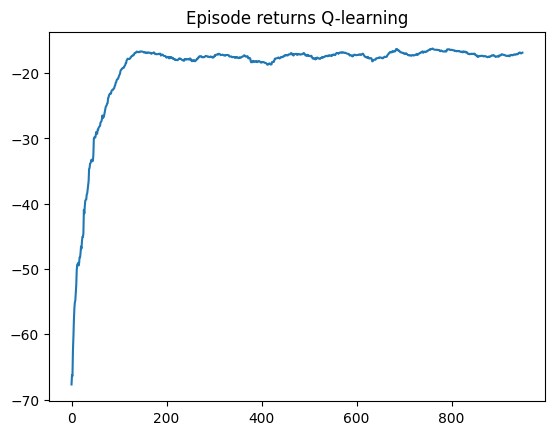

In [10]:
Q = np.zeros((env.nS, env.nA))
policy = EpsilonGreedyPolicy(Q, epsilon=0.1)
Q_q_learning, (episode_lengths_q_learning, episode_returns_q_learning) = q_learning(env, policy, Q, 1000)

n = 50
plt.plot(running_mean(episode_lengths_q_learning,n))
plt.title('Episode lengths Q-learning')
plt.show()
plt.plot(running_mean(episode_returns_q_learning,n))
plt.title('Episode returns Q-learning')
plt.show()

You will now compare the episode returns while learning for Q-learning and Sarsa by plotting the returns for both algorithms in a single plot, like in the book, Example 6.6. In order to be able to compare them, we will smooth the returns (e.g. plot the $n$ episode average instead).

Note that these plots will not be (auto)graded, but they might help you with finishing the homework exercises. 

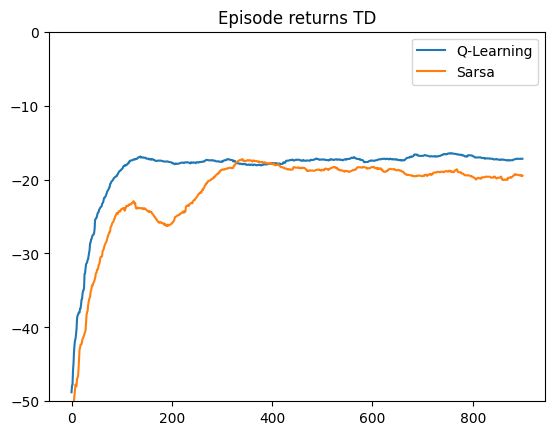

In [11]:
def running_mean(vals, n=1):
    cumvals = np.array(vals).cumsum()
    return (cumvals[n:] - cumvals[:-n]) / n

n = 100
plt.plot(running_mean(episode_returns_q_learning, n))
plt.plot(running_mean(episode_returns_sarsa, n))
plt.title('Episode returns TD')
plt.legend(['Q-Learning', 'Sarsa'])
plt.gca().set_ylim([-50, 0])
plt.show()

If you want to test/submit your solution **restart the kernel, run all cells and submit the td_autograde.py file into 
codegrade.**

in both sarsa and q learning, the running mean value go up exponentially. however, at around 100, sarsa's value dips a bit up until 200, where it goes back up.
this is because sarsa is an on-policy algorithm, meaning that it learns the policy that it is currently following. in contrast, q learning is an off-policy algorithm, meaning that it learns the best action to take from any given state, without following a specific policy.
the fluctuations in sarsa's values are because it is learning the policy it is following, which may not be the best policy. in contrast, q learning is learning the best action to take from any given state, without following a specific policy.  . in contrast, q learning is learning the best action to take from any given state, without following a specific policy.

100%|██████████| 1000/1000 [00:00<00:00, 1240.93it/s]


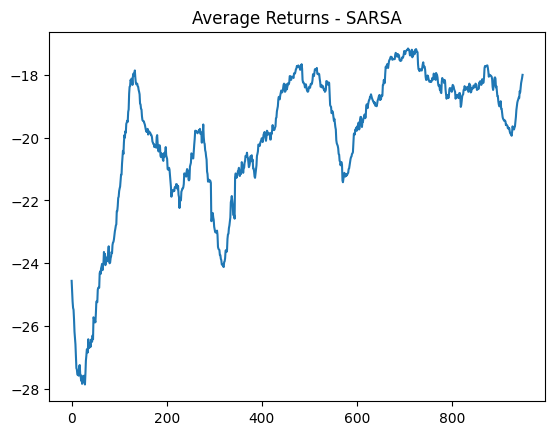

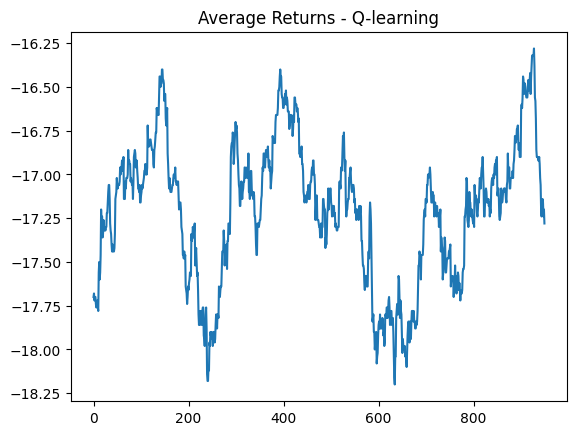

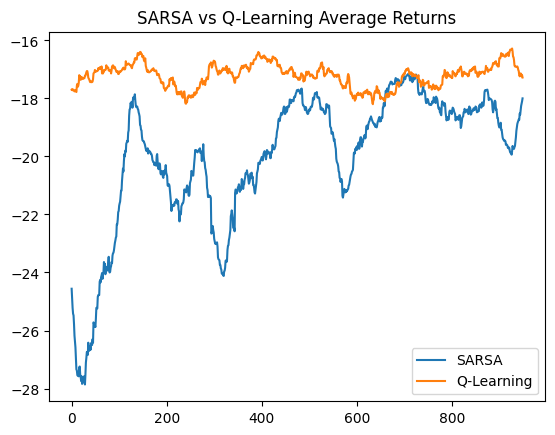

In [13]:
# Run SARSA
Q_sarsa, (episode_lengths_sarsa, episode_returns_sarsa) = sarsa(env, policy, Q, 1000)

# Run Q-learning
Q_qlearning, (episode_lengths_qlearning, episode_returns_qlearning) = q_learning(env, policy, Q, 1000)

# Calculate running means for the returns
n = 50  # Smoothing factor
sarsa_mean_return = running_mean(episode_returns_sarsa, n)
qlearning_mean_return = running_mean(episode_returns_qlearning, n)

# Plot average return for SARSA
plt.plot(sarsa_mean_return, label='SARSA')
plt.title('Average Returns - SARSA')
plt.show()

# Plot average return for Q-learning
plt.plot(qlearning_mean_return, label='Q-Learning')
plt.title('Average Returns - Q-learning')
plt.show()

# Compare both
plt.plot(sarsa_mean_return, label='SARSA')
plt.plot(qlearning_mean_return, label='Q-Learning')
plt.title('SARSA vs Q-Learning Average Returns')
plt.legend()
plt.show()


In [14]:
# Calculate variance of returns for SARSA
sarsa_variance = np.var(episode_returns_sarsa)

# Calculate variance of returns for Q-learning
qlearning_variance = np.var(episode_returns_qlearning)

print(f"SARSA Return Variance: {sarsa_variance}")
print(f"Q-Learning Return Variance: {qlearning_variance}")


SARSA Return Variance: 29.583775000000006
Q-Learning Return Variance: 6.5043999999999995
